#Introduction

This analysis explores the cellular landscape of the mouse bone marrow under normal, steady-state conditions using single-cell RNA-sequencing (scRNA-seq). The dataset, comprising 9,622 cells, focuses on vascular (VE-Cad+), perivascular (LEPR+), and osteoblast (COL2.3+) populations. Previous work on this data revealed considerable heterogeneity, identifying two endothelial, four perivascular, and three osteo-lineage subpopulations, plus a small proliferating cluster. Further details can be explored at http://aifantislab.com/niche.

This notebook aims to answer the following research question:

    Did each identified cell cluster within the vascular, perivascular, and osteo-lineage populations exhibit distinct, highly-expressed marker genes that align with their specific cell-type annotations?

In [5]:
import os
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
import numpy as np
from scipy.stats import median_abs_deviation



In [6]:
import warnings
warnings.simplefilter('ignore', FutureWarning)
warnings.simplefilter('ignore', RuntimeWarning)
warnings.simplefilter('ignore', UserWarning)

In [ ]:
os.getcwd()

'C:\\Users\\HP\\PycharmProjects\\pythonProject'

Pre-processing

In [ ]:
# This code processes gene expression data for different cell lines isolated from the bone marrow niches
# filters out low-quality cells and genes, and calculates metrics
# for mitochondrial and ribosomal gene expression before saving as a H5AD file.
#the mitchondrial and ribosomal count will be used to filter out low quality cells later on

files = os.listdir('./Lung Atlas') #directory that contains count matrices

def pre_processing(files):

    for file in files:
        cell_type = file.split('-')[1]
        cell_type = cell_type.split('.')[0]
        path = f'./Lung Atlas/{file}'

        adata = sc.read_text(path).T
        adata.X = csr_matrix(adata.X) #convert the count matrix to a sparse matrix

        sc.pp.filter_cells(adata, min_genes= 200)
        sc.pp.filter_genes(adata, min_cells=3)
        adata.var['mt'] = adata.var_names.str.startswith('Mt')
        adata.var['ribo'] = adata.var_names.str.startswith(('Rpl', 'Rps'))
        sc.pp.calculate_qc_metrics(adata, qc_vars=['mt', 'ribo'], inplace=True,
                                   percent_top = None, log1p = False)

        adata.write_h5ad(f'./data_h5ad/{cell_type}.h5ad')


In [ ]:
pre_processing(files)

In [ ]:
files = os.listdir('./data_h5ad')
def plot_metric(files):
    plot_list = []
    for file in files:
        cell_type = file.split('.')[0]
        fig, ax = plt.subplots()
        adata = sc.read_h5ad( f'./data_h5ad/{file}')
        sc.pl.violin(adata, ['pct_counts_mt'], ax=ax, show=False)
        ax.set_title(f'Mitochondrial Percentage - {cell_type}')
        plot_list.append(fig)


Analyzing the mitochondrial percentage across these cell populations reveals that all cell lines remain below 5%, with the majority of cells clustering tightly between 0% and 1%. thus, our cells are of good quality.

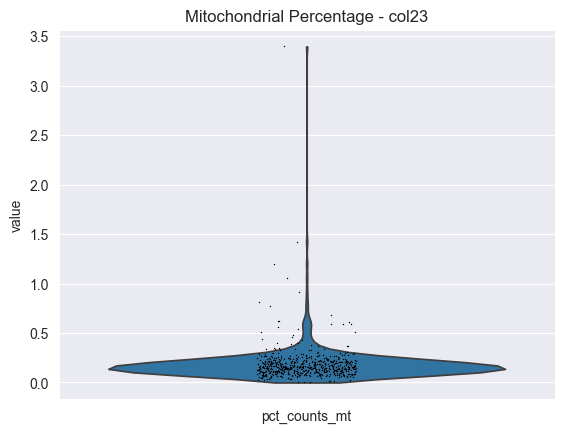

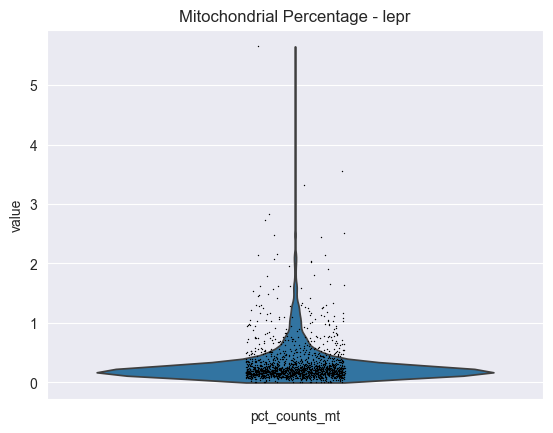

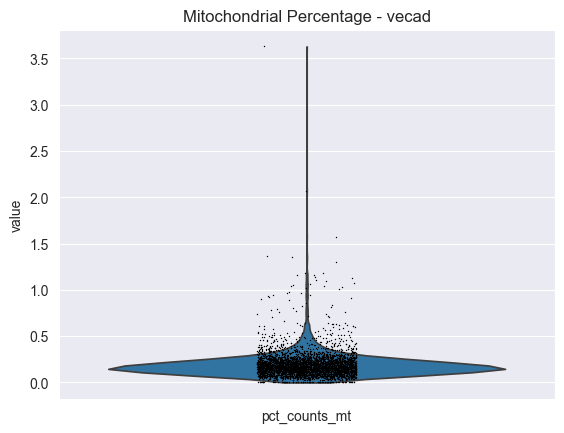

In [ ]:
plot_metric(files)

Ambient RNA correction

In [ ]:
import scvi
import os

/usr/local/lib/python3.11/dist-packages/docrep/decorators.py:43: SyntaxWarning: 'param_categorical_covariate_keys' is not a valid key!
  doc = func(self, args[0].__doc__, *args[1:], **kwargs)
/usr/local/lib/python3.11/dist-packages/docrep/decorators.py:43: SyntaxWarning: 'param_continuous_covariate_keys' is not a valid key!
  doc = func(self, args[0].__doc__, *args[1:], **kwargs)


In [ ]:
#in this step i removed doublet, which are two cells that are sequenced in the same droplet

def remove_doublet(files):
    for file in files:
      cell_type = file.split('.')[0]
      adata = sc.read_h5ad(f'./sample_data/{file}')
      scvi.model.SCVI.setup_anndata(adata)
      vae = scvi.model.SCVI(adata)
      vae.train()
      solo = scvi.external.SOLO.from_scvi_model(vae)
      solo.train()

      df = solo.predict()
      df['prediction'] = solo.predict(soft = False)
      df['dif'] = df.doublet - df.singlet
      doublets = df[(df.prediction == 'doublet') & (df.dif > 1)]

      adata.obs['doublet'] = adata.obs.index.isin(doublets.index)
      adata = adata[~adata.obs.doublet]

      adata.write_h5ad(f'./data_h5ad/{cell_type}.db.h5ad')

files = os.listdir('./data_h5ad')
remove_doublet(files)

#Data integration using scanorama

In [46]:
#since the cells came from different mice we need to account for the variability caused  by batch effect
files = os.listdir()
datas = []
for file in files:
    if 'db' in file:
        cell_line = file.split('.')[0]
        adata = sc.read_h5ad(file)
        adata.obs['Sample'] = cell_line
        adata.layers['counts'] = adata.X.copy()
        sc.pp.normalize_total(adata, inplace=True)
        sc.pp.log1p(adata)
        sc.pp.highly_variable_genes(adata, flavor='seurat', inplace=True)
        datas.append(adata)

In [48]:
scanorama.integrate_scanpy(datas)

Found 12022 genes among all datasets
[[0.         0.63476874 0.37799043]
 [0.         0.         0.10473525]
 [0.         0.         0.        ]]
Processing datasets (0, 1)
Processing datasets (0, 2)
Processing datasets (1, 2)


In [49]:
adata = sc.concat(datas, index_unique='_')

In [50]:
#Get the integrated matrices
scanorama_int = [ad.obsm['X_scanorama'] for ad in datas]
#make them into one matrix
adata.obsm['scanorama'] = np.concatenate(scanorama_int)

In [42]:
sc.pp.neighbors(adata, use_rep='scanorama')
sc.tl.umap(adata)


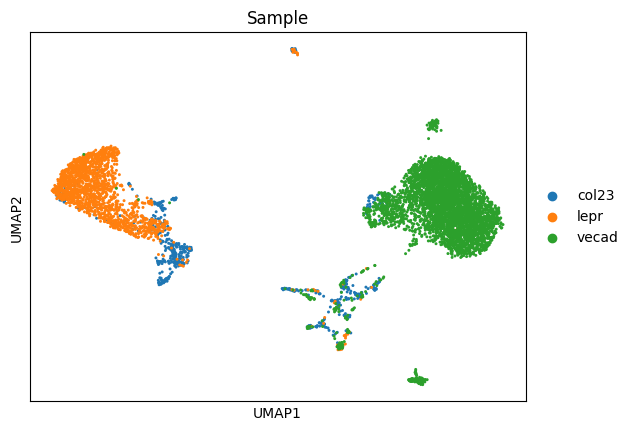

In [43]:
sc.pl.umap(adata, color='Sample')

In [55]:
#dimensiality reduction with tSNE
sc.tl.tsne(adata, use_rep='scanorama')


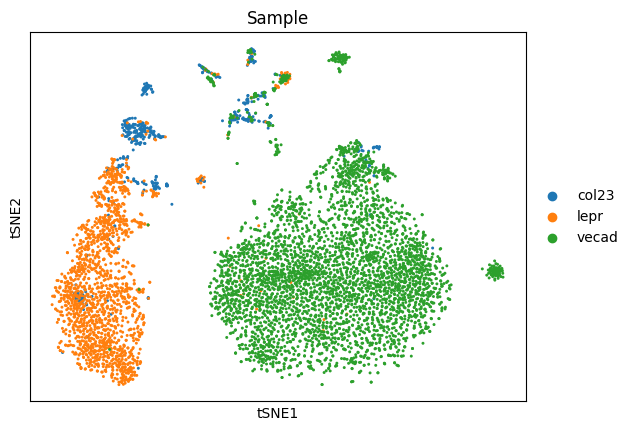

In [54]:
sc.pl.tsne(adata, color='Sample')

#Data integration using SCVI

In [3]:
import scanpy as sc
import scvi
import os
import numpy as np

/usr/local/lib/python3.11/dist-packages/docrep/decorators.py:43: SyntaxWarning: 'param_categorical_covariate_keys' is not a valid key!
  doc = func(self, args[0].__doc__, *args[1:], **kwargs)
/usr/local/lib/python3.11/dist-packages/docrep/decorators.py:43: SyntaxWarning: 'param_continuous_covariate_keys' is not a valid key!
  doc = func(self, args[0].__doc__, *args[1:], **kwargs)


In [7]:
files = os.listdir()
datas = []
for file in files:
    if 'db' in file:
        cell_line = file.split('.')[0]
        adata = sc.read_h5ad(file)
        adata.obs['Sample'] = cell_line
        datas.append(adata)

In [10]:
len(datas)

3

In [12]:
adata = sc.concat(datas, index_unique='_')

In [13]:
adata

AnnData object with n_obs × n_vars = 6626 × 12022
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'Sample'

In [15]:
#save a copy of the raw count in a separate layer
adata.layers['counts'] = adata.X.copy()

scvi.model.SCVI.setup_anndata(
    adata,
    layer = 'counts',
    categorical_covariate_keys=['Sample'],
    continuous_covariate_keys=['total_counts']
)

model = scvi.model.SCVI(adata)

In [16]:
model.train()

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Training:   0%|          | 0/400 [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=400` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=400` reached.


In [17]:
#latent representation of the integrated data, will be using for clustering and visualization
adata.obsm['X_scVI'] = model.get_latent_representation()

In [18]:
#Normalized raw count
adata.layers['scvi_normalized'] = model.get_normalized_expression(library_size= 1e4)

In [27]:
sc.pp.normalize_total(adata, target_sum = 1e4)
sc.pp.log1p(adata)
adata.raw = adata

In [28]:
adata

AnnData object with n_obs × n_vars = 6626 × 12022
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'Sample', '_scvi_batch', '_scvi_labels'
    uns: '_scvi_uuid', '_scvi_manager_uuid', 'log1p'
    obsm: '_scvi_extra_categorical_covs', '_scvi_extra_continuous_covs', 'X_scVI'
    layers: 'counts', 'scvi_normalized'

In [29]:
#find neighbors in latent space that will be clustered together
sc.pp.neighbors(adata, use_rep='X_scVI')

In [39]:
import leidenalg

In [40]:
sc.tl.umap(adata)
sc.tl.leiden(adata, resolution = 0.5)

<ipython-input-40-609141d0aa88>:2: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, resolution = 0.5)


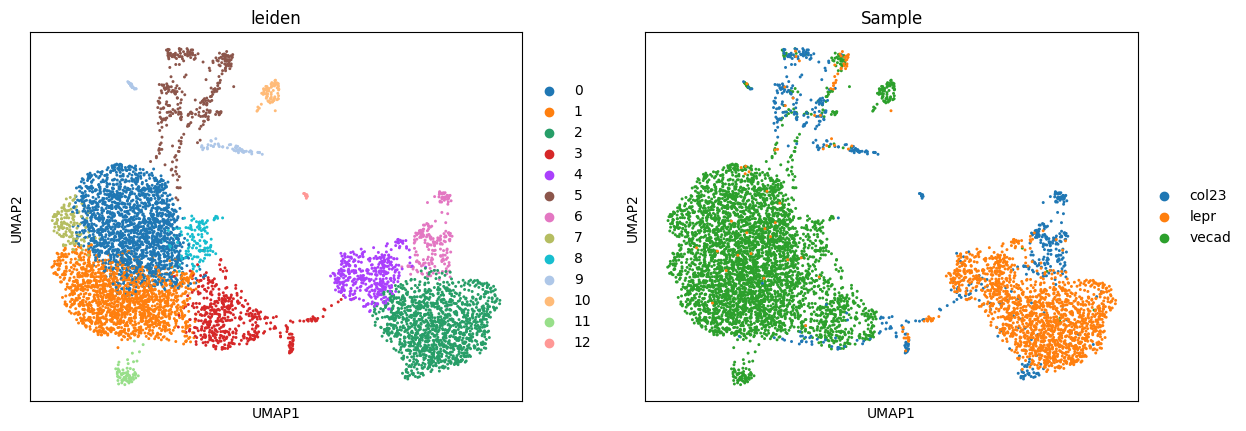

In [41]:
sc.pl.umap(adata, color = ['leiden', 'Sample'])

In [42]:
#dimensiality reduction with tSNE
sc.tl.tsne(adata, use_rep='X_scVI')


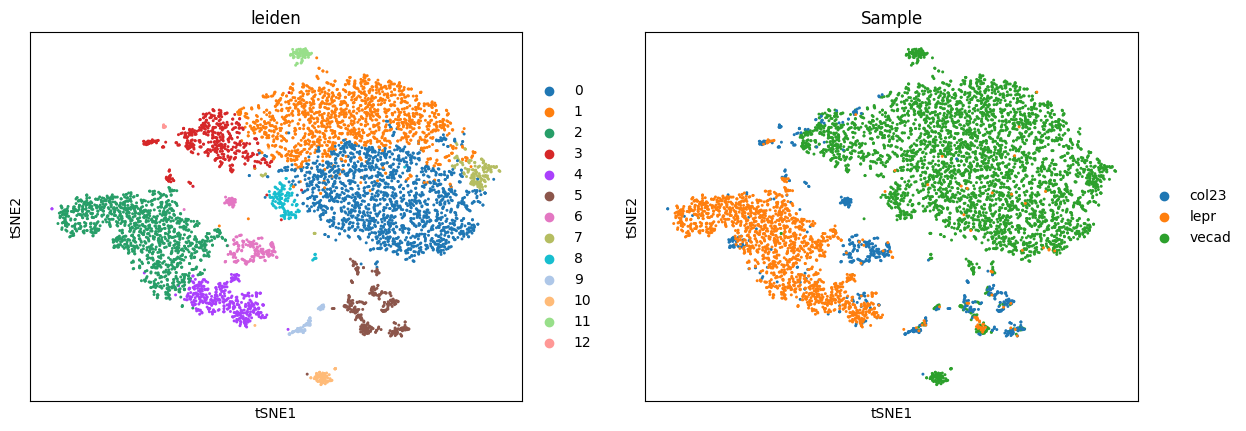

In [43]:
sc.pl.tsne(adata, color=['leiden', 'Sample'])

In [45]:
adata.write_h5ad('intergrated.h5ad')

In [3]:
adata = sc.read_h5ad('./data_h5ad/intergrated.h5ad')

##Find Marker Genes

I have collected some marker genes for annotation through literature review mainly from https://doi.org/10.3389/fcell.2021.787118

In [4]:
adata

AnnData object with n_obs × n_vars = 6626 × 12022
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'Sample', '_scvi_batch', '_scvi_labels', 'leiden'
    uns: 'Sample_colors', '_scvi_manager_uuid', '_scvi_uuid', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'tsne', 'umap'
    obsm: 'X_scVI', 'X_tsne', 'X_umap', '_scvi_extra_categorical_covs', '_scvi_extra_continuous_covs'
    layers: 'counts', 'scvi_normalized'
    obsp: 'connectivities', 'distances'

In [8]:
sc.tl.rank_genes_groups(adata, 'leiden')

In [36]:
marker_genes = {
    'Arterial': ['Ly6a', 'Icam2', 'Cd34', 'Ly6c1'],# Arterial Associated  and surface markers
    'Sinusoids' : ['Stab2', 'Flt4', 'Icam1'], #Sinusoids associated marker genes
    'Osteocyte' : ['Runx3', 'Ibsp', 'Ncam1', 'Spp1', 'Bglap'],
    'Adipocyte' : ['Cebpa', 'Cebpb', 'Pparg', 'Lpl', 'Adipoq', 'Apoe', 'Itgb1'],
    'Chrondcyte' : ['Sox9', 'Pth1r', 'Gla']
}

ARTERIAL


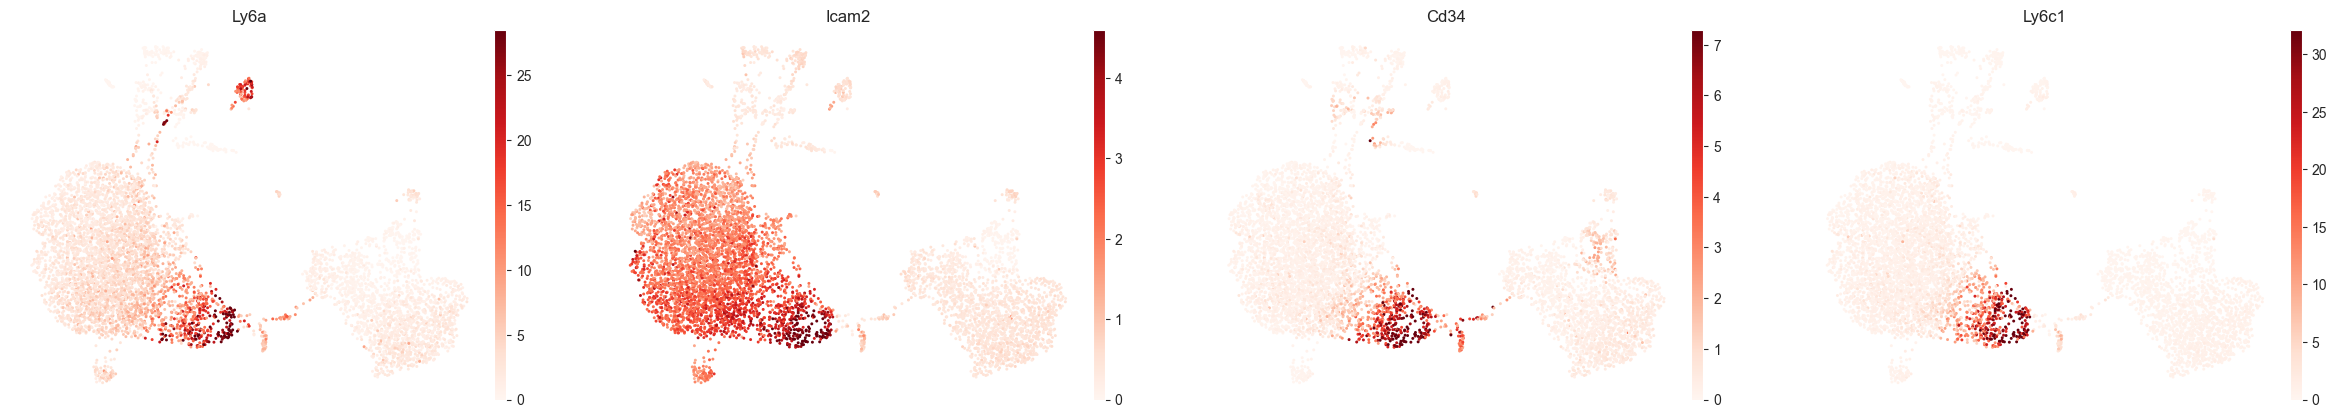

SINUSOIDS


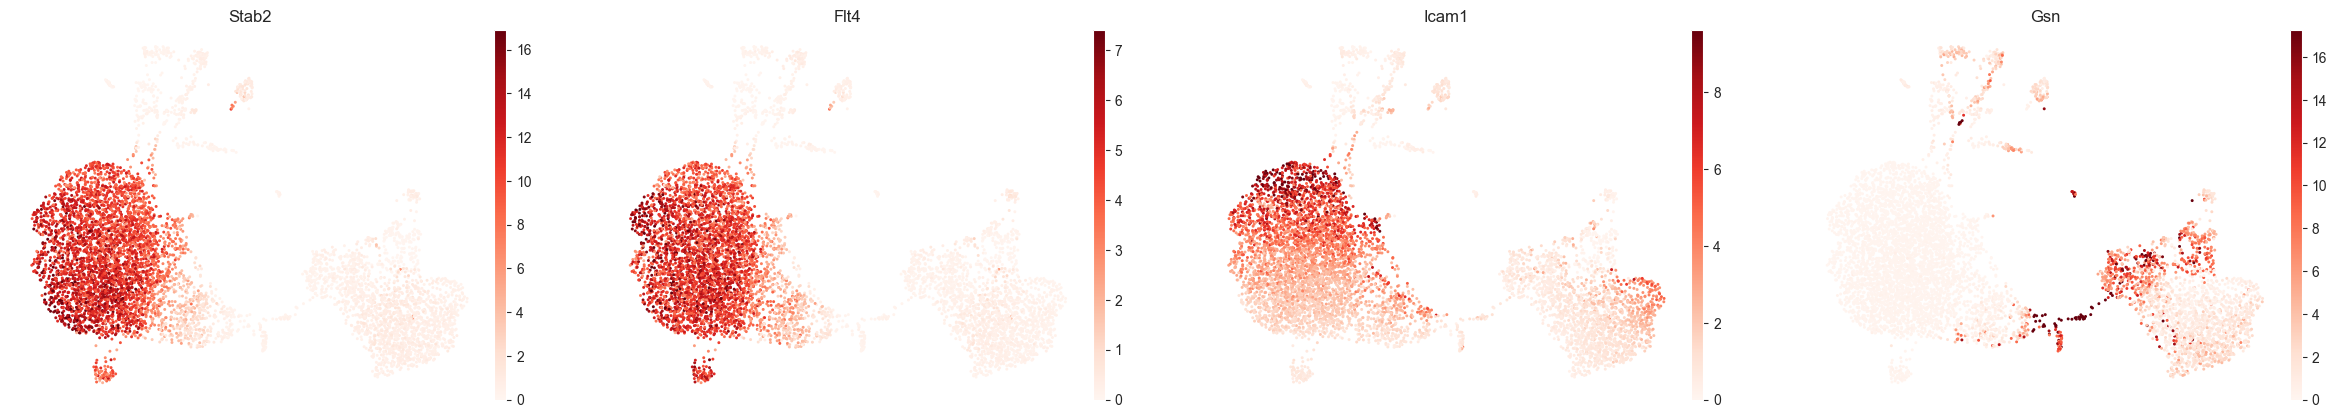

OSTEOCYTE


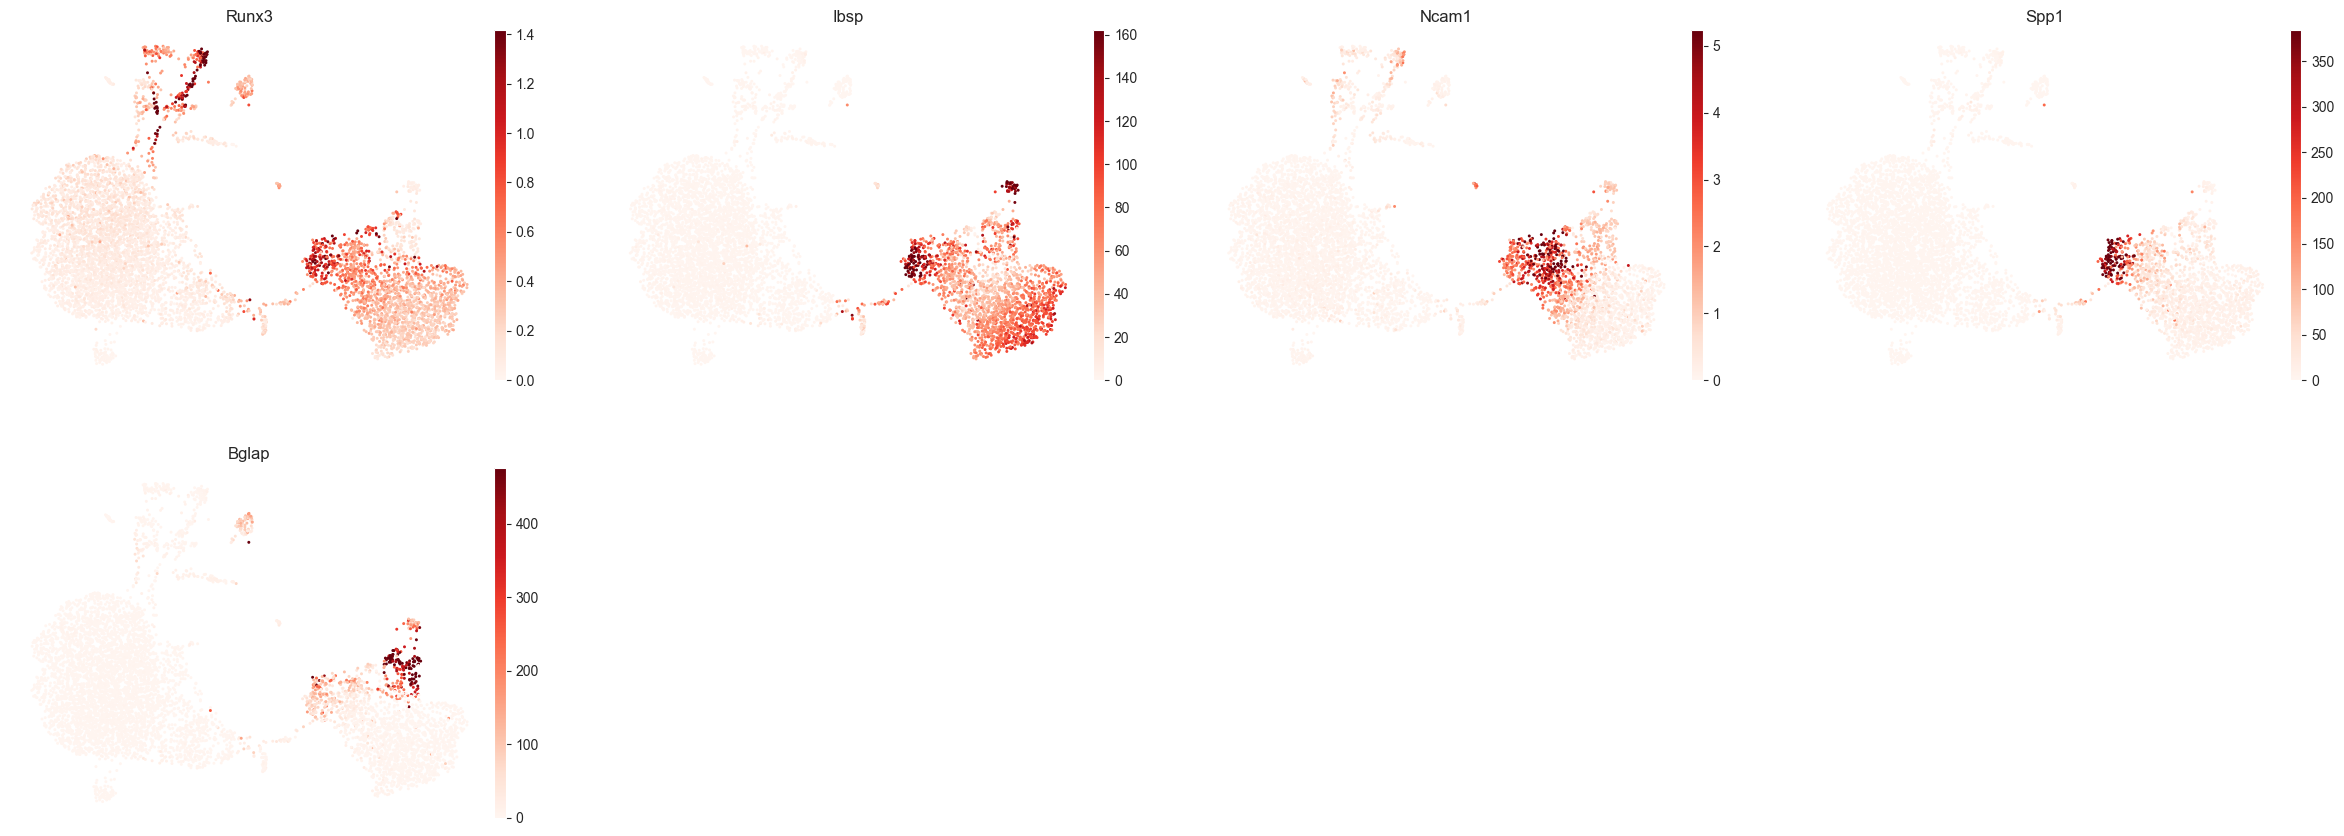

ADIPOCYTE


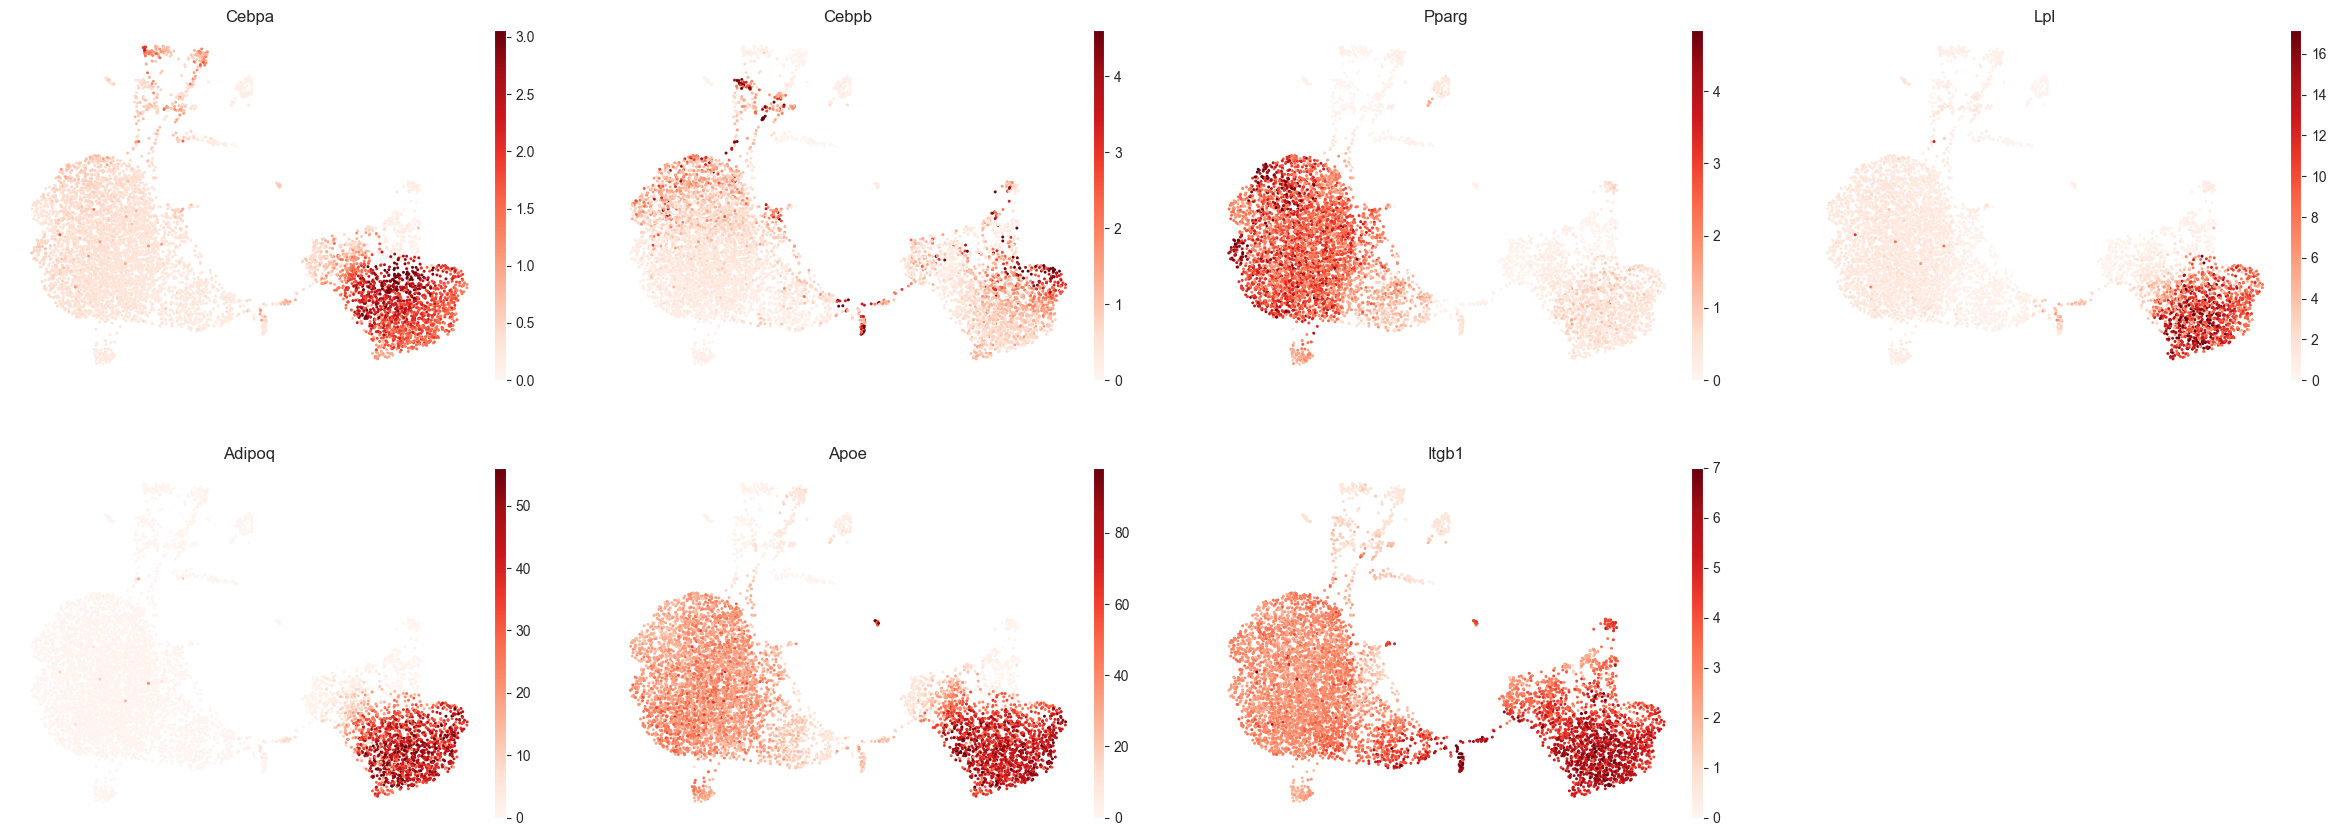

CHRONDCYTE


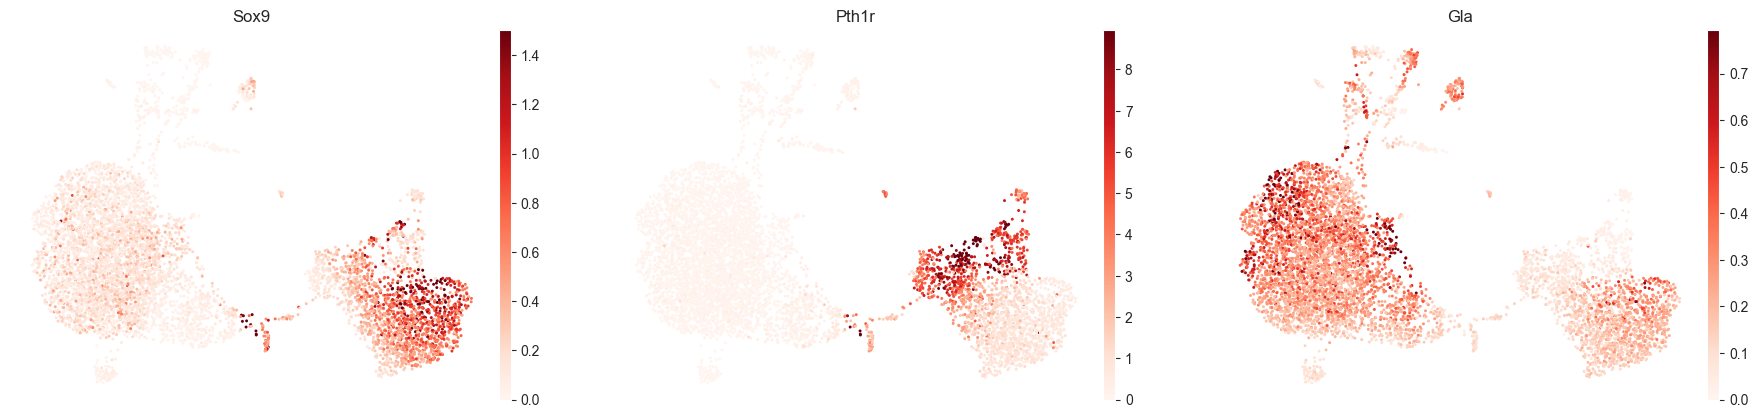

In [37]:
for cell_type, genes in marker_genes.items():
  print(f'{cell_type.upper()}')
  sc.pl.umap(
        adata,
        color=marker_genes[cell_type],
        vmin=0,
        vmax="p99",  # set vmax to the 99th percentile of the gene count instead of the maximum, to prevent outliers from making expression in other cells invisible. Note that this can cause problems for extremely lowly expressed genes.
        sort_order=False,  # do not plot highest expression on top, to not get a biased view of the mean expression among cells
        frameon=False,
        cmap="Reds",
        layer = 'scvi_normalized',
    )

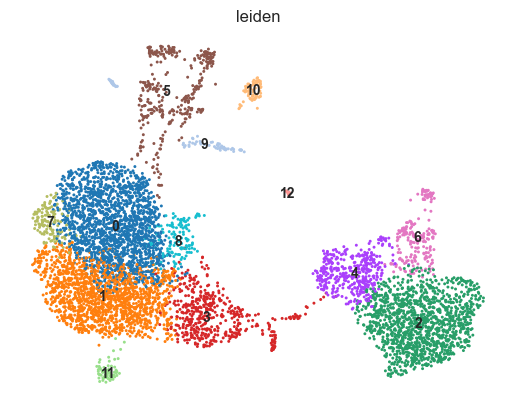

In [72]:
sc.pl.umap(adata, color= ['leiden'], frameon = False, legend_loc = 'on data')

From examining the different marker genes, it seems the resolution I chose for Leiden clustering over-clustered Arterial Cells, so I will reassign and coalesce clusters based on the marker genes.

In [38]:
adata.obs['leiden'][adata.obs['leiden'].isin(['1', '7', '8', '11'])] = '0'
adata.obs['leiden']=adata.obs['leiden'].astype('str').astype('category')
### Reorder and rename the Leiden
cluster_mapping = dict(zip(np.unique(adata.obs['leiden']), np.arange(len(np.unique(adata.obs['leiden'])))))
adata.obs['leiden'] = adata.obs['leiden'].replace(cluster_mapping)
adata.obs['leiden'] =adata.obs['leiden'].astype('str')
adata.obs['leiden'] =adata.obs['leiden'].astype('category')

Cluster 7 doesn't really express Chrondycte marker genes, from the initial clustering it seems to be the only cluster expressing BGLAP, which is a Osteoblast gene marker.

to investigate the cell identity of the remaining clusters, i will rank the most expressed genes for each cluster and look them up in PangaoDB database to infer the cell identity.

In [14]:
sc.tl.rank_genes_groups(
    adata, groupby="leiden", method="wilcoxon", key_added="leiden_normalized",
    layer = 'scvi_normalized', use_raw = False
)

In [48]:
sc.tl.rank_genes_groups(
    adata, groupby="leiden", method="wilcoxon", key_added="leiden_raw",
)

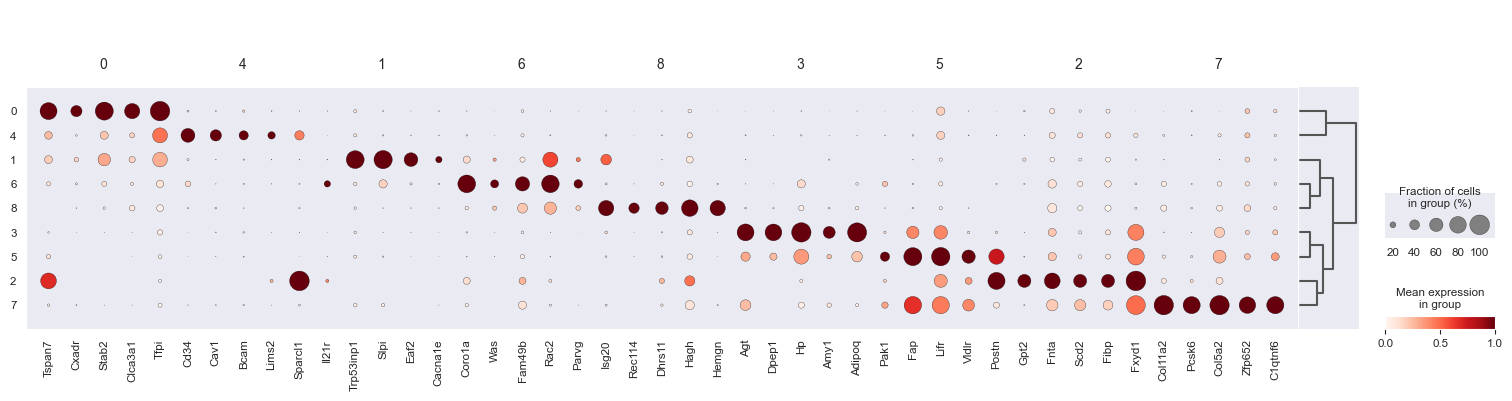

In [49]:
sc.pl.rank_genes_groups_dotplot(
    adata, groupby="leiden", standard_scale="var", n_genes=5, key="leiden_normalized",
)

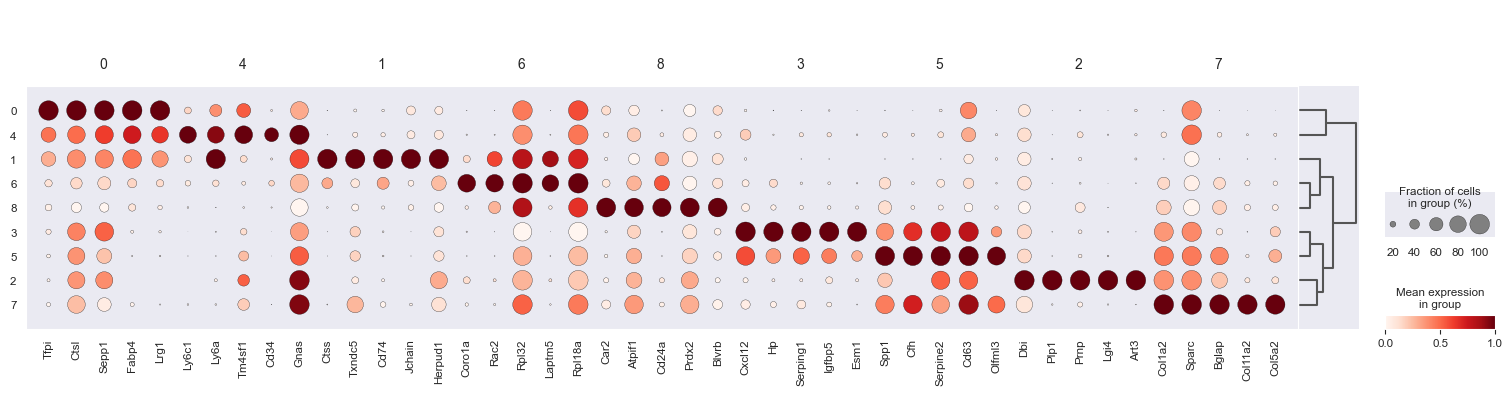

In [50]:
sc.pl.rank_genes_groups_dotplot(
    adata, groupby="leiden", standard_scale="var", n_genes=5, key="leiden_raw",
)

For cluster 7, after looking up the top-ranked genes in both normalized and raw counts, it seems that they are mostly expressed in fibroblasts and osteoblasts. However, the absence of Vcam-1 and Fbln2 combined with high expression of BGLAP and Car3 in the cluster makes me lean towards the cluster representing mature osteoblast.

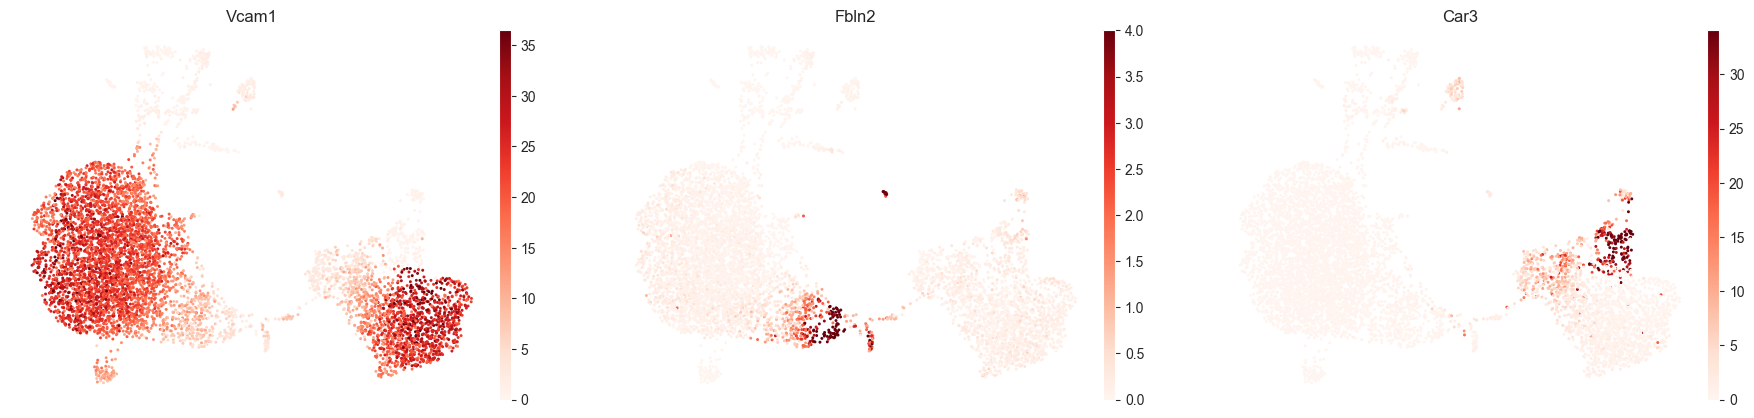

In [30]:
sc.pl.umap(adata, color= ['Vcam1', 'Fbln2', 'Car3'], vmin=0,vmax="p99", sort_order=False, frameon=False, cmap="Reds", layer = 'scvi_normalized')

For cluster 8 and 6, the markers are for immune cells; one sub-cluster within expresses primarily Cd79a and CD19, which are B cell marker genes. and another expressing the marker for cells undergoing division (Mki67).

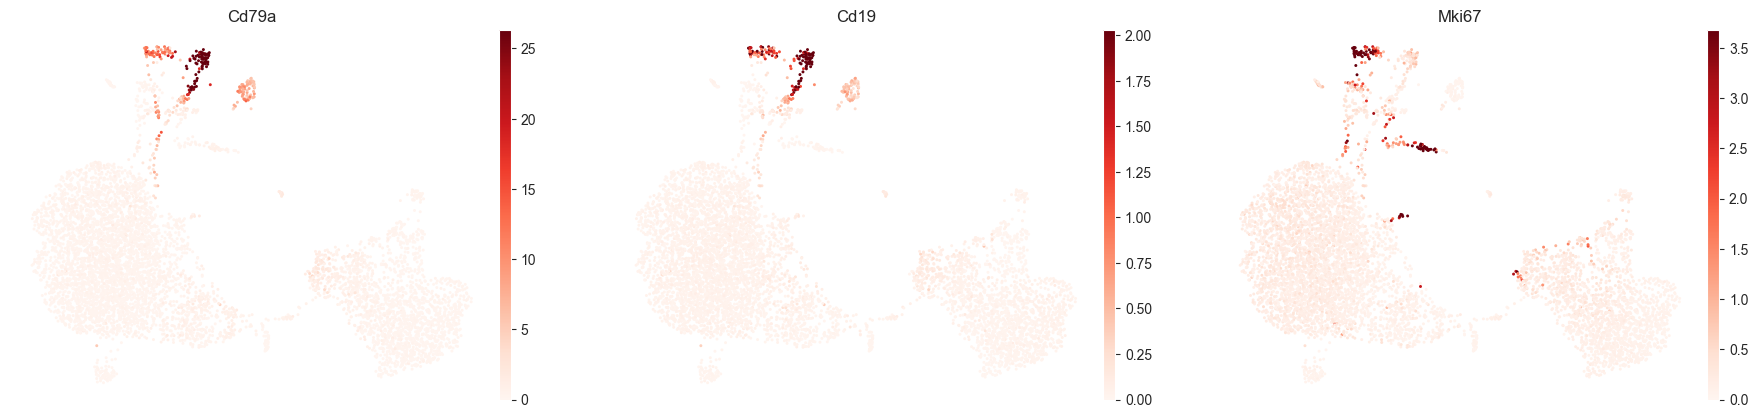

In [49]:
sc.pl.umap(adata, color= ['Cd79a', 'Cd19', 'Mki67'], vmin=0,vmax="p99", sort_order=False, frameon=False, cmap="Reds", layer = 'scvi_normalized')

In [61]:
adata.obs['leiden'][adata.obs['leiden'].isin(['1', '8', '2'])] = '6'
adata.obs['leiden']=adata.obs['leiden'].astype('str').astype('category')
### Reorder and rename the Leiden
cluster_mapping = dict(zip(np.unique(adata.obs['leiden']), np.arange(len(np.unique(adata.obs['leiden'])))))
adata.obs['leiden'] = adata.obs['leiden'].replace(cluster_mapping)
adata.obs['leiden'] =adata.obs['leiden'].astype('str')
adata.obs['leiden'] =adata.obs['leiden'].astype('category')

In [46]:
cell_types = {'0' : 'Arterial Cells',
 '2'  : 'Sinusiods cells',
 '1'  : 'Adipocyte',
 '3' : 'Osteocyte',
 '5' : 'Mature Osteoblast',
 '4'  : 'Immune cells'
 }

In [47]:
#mapping the clusters to cell types
adata.obs['cell_type'] = adata.obs.leiden.map(cell_types)

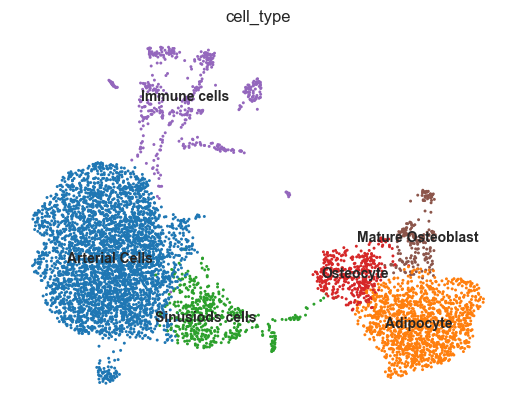

In [48]:
sc.pl.umap(adata, color= ['cell_type'], frameon = False, legend_loc = 'on data')

In [80]:
adata.write_h5ad('./data_h5ad/integrated2.h5ad')

In [7]:
adata = sc.read_h5ad('./data_h5ad/integrated2.h5ad')

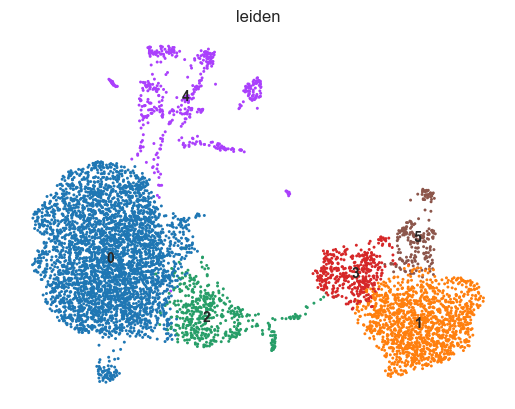

In [17]:
sc.pl.umap(adata, color= ['leiden'], frameon = False, legend_loc = 'on data')


**Result discussion**

Here i presented a preliminary analysis of a scRNA-seq dataset detailing the mouse bone marrow microenvironment at a steady state. my analysis aimed to address the research question posed in the Introduction section.

Following data preprocessing and clustering of the vascular (VE-Cad+), perivascular (LEPR+), and osteo-lineage (COL2.3+) populations, my analysis largely identified cell clusters corresponding to distinct cell population through the examination of differentially expressed marker genes and known marker genes. The expression of these marker genes generally allowed for the annotation of cell types characteristic of the bone marrow niche.

However, it was observed that some previously established marker genes for certain original clusters appeared to have diminished or absent, such as. This could potentially be attributed to over-correction effects stemming from data integration methods applied during the preprocessing stages such as Wif1. Additionally, some cells weren't clearly separated, Such as Sinusoids cells and osteogenic cells undergoing differentiation.

